# Finding similar items

### Load dataset from Kaggle

In [17]:
!pip install -q kaggle

from google.colab import files
files.upload()

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d 'asaniczka/1-3m-linkedin-jobs-and-skills-2024'
! mkdir jobs
! unzip 1-3m-linkedin-jobs-and-skills-2024.zip -d jobs

Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
100% 1.88G/1.88G [01:05<00:00, 33.1MB/s]
100% 1.88G/1.88G [01:05<00:00, 30.8MB/s]
Archive:  1-3m-linkedin-jobs-and-skills-2024.zip
  inflating: jobs/job_skills.csv     
  inflating: jobs/job_summary.csv    
  inflating: jobs/linkedin_job_postings.csv  


In [6]:
# Create a sampe of the dataframe to simplify the future upload
import pandas as pd
df = pd.read_csv('jobs/job_summary.csv')
df.sample(10_000, random_state=42).to_csv("jobs/job_summary_sample.csv", index_label="index")

### Configure Pyspark

In [1]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash /dev/stdin -p 3.5.1 -s 5.3.3

--2024-06-11 13:13:04--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2024-06-11 13:13:05--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1191 (1.2K) [text/plain]
Saving to: ‘STDOUT’

-                     0%[                    ]       0  --.-KB/s               Installing PySpark 3.2.3 and Spark NLP 5.3.3
setup Colab for PySpark 3.2.3 an

### Load the data

In [1]:
import sparknlp

spark = sparknlp.start()

In [2]:
raw_df = spark.read.csv("jobs/job_summary_sample.csv", header=True, inferSchema=True, multiLine=True, escape="\"")
raw_df.show(5, False)

+-------+--------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Text tokenization and cleaning

In [3]:
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import DocumentAssembler, Finisher, Pipeline
from sparknlp.annotator import Tokenizer, Normalizer, StopWordsCleaner, Stemmer
from pyspark.sql.functions import concat_ws

# Define the NLP pipeline
document_assembler = DocumentAssembler() \
    .setInputCol("job_summary") \
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized") \
    .setLowercase(True)

stopwords_cleaner = StopWordsCleaner() \
    .setInputCols(["normalized"]) \
    .setOutputCol("clean_tokens") \
    .setCaseSensitive(False)

stemmer = Stemmer() \
    .setInputCols(["clean_tokens"]) \
    .setOutputCol("stem")

finisher = Finisher() \
    .setInputCols(["stem"]) \
    .setOutputCols(["clean_tokens"]) \
    .setOutputAsArray(True) \
    .setCleanAnnotations(False)

# Apply to the data
pipeline = Pipeline(stages=[document_assembler, tokenizer, normalizer, stopwords_cleaner, stemmer, finisher])
model = pipeline.fit(raw_df)
cleaned_df = model.transform(raw_df)

cleaned_df = cleaned_df \
        .select("index", "job_summary", "clean_tokens") \
        .cache()

In [5]:
cleaned_df.show(5, False)

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Sentence embedding

In [4]:
from pyspark.ml.feature import HashingTF, IDF
from pyspark.sql.functions import udf, col, explode
from pyspark.sql.types import ArrayType, FloatType

# Apply HashingTF
hashing_tf = HashingTF(inputCol="clean_tokens", outputCol="tf", numFeatures=10_000)
feat_data = hashing_tf.transform(cleaned_df)

# Compute the TF-IDF values
idf = IDF(inputCol="tf", outputCol="tf_idf", minDocFreq=5)
df = idf.fit(feat_data).transform(feat_data).cache()

In [5]:
df.show(5, False)

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Top frequent words

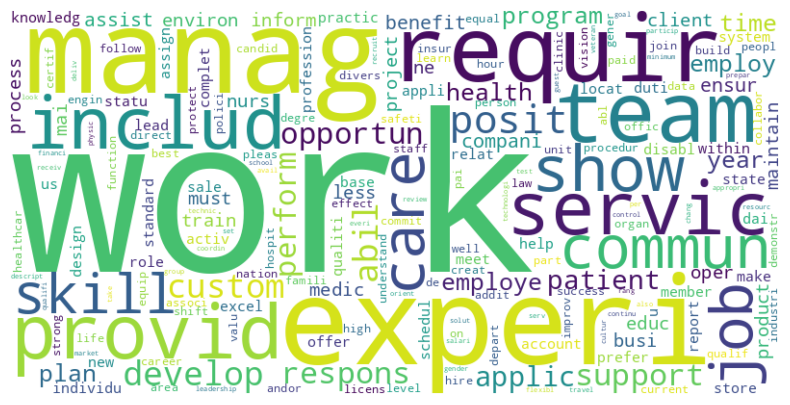

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_freq_df = df \
    .withColumn("word", explode(col("clean_tokens"))) \
    .groupBy("word").count() \
    .orderBy("count", ascending=False)

word_freq_pd = word_freq_df.toPandas().set_index('word')['count'].to_dict()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_pd)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [9]:
print("Total number of unique words %.d" % word_freq_df.count())

Total number of unique words 57856


## Modeling

In [10]:
pairs = df.alias("df1") \
    .limit(100) \
    .crossJoin(df.alias("df2")) \
    .filter(col("df1.index") > col("df2.index")) \
    .select(
        col("df1.job_summary").alias("job_summary_1"),
        col("df2.job_summary").alias("job_summary_2"),
        col("df1.tf").alias("tf_1"),
        col("df2.tf").alias("tf_2"),
        col("df1.tf_idf").alias("tfidf_1"),
        col("df2.tf_idf").alias("tfidf_2")
    )

### Top similar pairs based on Jaccard distance between BOW

In [11]:
def jaccard_similarity(sv1, sv2):
    set1 = set(sv1.indices)
    set2 = set(sv2.indices)
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    if union == 0:
        return 0.0
    return intersection / union

jaccard_udf = udf(jaccard_similarity, FloatType())

pairs_with_jaccard_similarity = pairs \
    .withColumn("jaccard_similarity", jaccard_udf(col("tf_1"), col("tf_2"))) \
    .select("job_summary_1", "job_summary_2", "jaccard_similarity") \
    .orderBy(col("jaccard_similarity").desc()) \
    .cache()

pairs_with_jaccard_similarity.show(30, False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Number of pairs with respect to the Jaccard Similarity Score

In [12]:
print("%d pairs with 100%% Jaccard similarity" % pairs_with_jaccard_similarity.filter(col('jaccard_similarity') == 1).count())
print("%d pairs with 80%%-99%% Jaccard similarity" % pairs_with_jaccard_similarity.filter((col('jaccard_similarity') >= 0.8) & (col('jaccard_similarity') < 1)).count())
print("%d pairs with 60%%-79%% Jaccard similarity" % pairs_with_jaccard_similarity.filter((col('jaccard_similarity') >= 0.6) & (col('jaccard_similarity') < 0.8)).count())
print("%d pairs with 40%%-59%% Jaccard similarity" % pairs_with_jaccard_similarity.filter((col('jaccard_similarity') >= 0.4) & (col('jaccard_similarity') < 0.6)).count())
print("%d pairs with 20%%-39%% Jaccard similarity" % pairs_with_jaccard_similarity.filter((col('jaccard_similarity') >= 0.2) & (col('jaccard_similarity') < 0.4)).count())
print("%d pairs with less than 20%% Jaccard similarity" % pairs_with_jaccard_similarity.filter((col('jaccard_similarity') < 0.2)).count())

64 pairs with 100% Jaccard similarity
39 pairs with 80%-99% Jaccard similarity
12 pairs with 60%-79% Jaccard similarity
172 pairs with 40%-59% Jaccard similarity
28443 pairs with 20%-39% Jaccard similarity
494460 pairs with less than 20% Jaccard similarity


### Top similar pairs based on Cosine similarity between TF-IDF vectors

In [13]:
def cosine_similarity(v1, v2):
    dot_product = float(v1.dot(v2))
    norm_v1 = float(v1.norm(2))
    norm_v2 = float(v2.norm(2))
    if norm_v1 * norm_v2 == 0:
      return 0
    return dot_product / (norm_v1 * norm_v2)

cosine_similarity_udf = udf(cosine_similarity, FloatType())

pairs_with_cosine_similarity = pairs \
    .withColumn("cosine_similarity", cosine_similarity_udf(col("tfidf_1"), col("tfidf_2"))) \
    .select("job_summary_1", "job_summary_2", "cosine_similarity") \
    .orderBy(col("cosine_similarity").desc()) \
    .cache()

pairs_with_cosine_similarity.show(30, False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
print("%d pairs with 100%% Cosine similarity" % pairs_with_cosine_similarity.filter(col('cosine_similarity') == 1).count())
print("%d pairs with 80%%-99%% Cosine similarity" % pairs_with_cosine_similarity.filter((col('cosine_similarity') >= 0.8) & (col('cosine_similarity') < 1)).count())
print("%d pairs with 60%%-79%% Cosine similarity" % pairs_with_cosine_similarity.filter((col('cosine_similarity') >= 0.6) & (col('cosine_similarity') < 0.8)).count())
print("%d pairs with 40%%-59%% Cosine similarity" % pairs_with_cosine_similarity.filter((col('cosine_similarity') >= 0.4) & (col('cosine_similarity') < 0.6)).count())
print("%d pairs with 20%%-39%% Cosine similarity" % pairs_with_cosine_similarity.filter((col('cosine_similarity') >= 0.2) & (col('cosine_similarity') < 0.4)).count())
print("%d pairs with less than 20%% Cosine similarity" % pairs_with_cosine_similarity.filter((col('cosine_similarity') < 0.2)).count())

64 pairs with 100% Cosine similarity
53 pairs with 80%-99% Cosine similarity
142 pairs with 60%-79% Cosine similarity
359 pairs with 40%-59% Cosine similarity
6472 pairs with 20%-39% Cosine similarity
516100 pairs with less than 20% Cosine similarity


### K-Means clustering 100

In [6]:
from pyspark.ml.clustering import BisectingKMeans

bkm_100 = BisectingKMeans(featuresCol="tf_idf", predictionCol="cluster", k=100)

clusters_100 = bkm_100.fit(df).transform(df).select("cluster", "index", "job_summary")

In [7]:
cluster_count = clusters_100.groupby("cluster").count().orderBy("count", ascending=False)
cluster_count.show(100, False)

+-------+-----+
|cluster|count|
+-------+-----+
|0      |1183 |
|5      |1004 |
|24     |797  |
|1      |733  |
|27     |637  |
|6      |623  |
|14     |544  |
|9      |446  |
|26     |400  |
|34     |316  |
|3      |278  |
|15     |276  |
|47     |266  |
|49     |256  |
|25     |243  |
|48     |229  |
|8      |149  |
|35     |149  |
|37     |141  |
|7      |133  |
|21     |89   |
|50     |82   |
|10     |70   |
|52     |69   |
|4      |65   |
|36     |61   |
|51     |55   |
|22     |54   |
|17     |52   |
|11     |51   |
|13     |49   |
|2      |44   |
|23     |40   |
|53     |36   |
|20     |35   |
|16     |32   |
|12     |30   |
|32     |26   |
|58     |25   |
|54     |21   |
|39     |16   |
|40     |15   |
|29     |14   |
|33     |13   |
|45     |13   |
|28     |11   |
|59     |10   |
|60     |9    |
|18     |9    |
|31     |8    |
|38     |7    |
|30     |7    |
|56     |6    |
|19     |5    |
|63     |4    |
|68     |4    |
|64     |4    |
|65     |3    |
|55     |3    |
|62     

**Clusters with 100+ samples** seem to have more similar but still quite different job offerings

In [10]:
clusters_100.filter("cluster == 7").show(10, False)

+-------+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Clusters with less than 30 samples** finally have some meaningful results and indeed collect very similar job offerings.

In [11]:
clusters_100.filter("cluster == 12").show(20, False)

+-------+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [12]:
clusters_100.filter("cluster == 16").show(20, False)

+-------+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### K-Means clustering 1000

In [8]:
from pyspark.ml.clustering import BisectingKMeans

bkm_1000 = BisectingKMeans(featuresCol="tf_idf", predictionCol="cluster", k=1000)

# Fit the model
clusters_1000 = bkm_1000 \
    .fit(df) \
    .transform(df) \
    .select("cluster", "index", "job_summary")

In [9]:
cluster_count = clusters_1000.groupby("cluster").count().orderBy("count", ascending=False)
cluster_count.show(100, False)

+-------+-----+
|cluster|count|
+-------+-----+
|17     |236  |
|11     |197  |
|18     |163  |
|12     |144  |
|19     |106  |
|20     |96   |
|116    |95   |
|32     |85   |
|119    |81   |
|120    |80   |
|111    |76   |
|31     |75   |
|314    |74   |
|313    |73   |
|37     |69   |
|113    |69   |
|33     |69   |
|38     |66   |
|431    |63   |
|13     |62   |
|439    |62   |
|315    |62   |
|34     |61   |
|29     |58   |
|117    |56   |
|148    |54   |
|440    |53   |
|316    |52   |
|114    |52   |
|112    |50   |
|448    |48   |
|221    |48   |
|531    |46   |
|514    |45   |
|121    |45   |
|151    |45   |
|433    |44   |
|154    |43   |
|447    |43   |
|118    |43   |
|122    |43   |
|222    |43   |
|153    |42   |
|517    |41   |
|229    |41   |
|164    |40   |
|367    |40   |
|515    |40   |
|163    |39   |
|224    |39   |
|152    |39   |
|149    |38   |
|449    |38   |
|518    |38   |
|30     |38   |
|150    |38   |
|317    |36   |
|232    |36   |
|444    |36   |
|520    

In [15]:
clusters_1000.filter("cluster == 15").show(10, False)

+-------+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
clusters_1000.filter("cluster == 453").show(10, False)

+-------+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------